# Import Libraries

In [1]:
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import defaultdict
from dataset import dataset_MOT_segmented
from models import vqvae
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load Data

In [ ]:
# Create the data loader (adjust window_size, batch_size as needed)
loader = dataset_MOT_segmented.addb_data_loader(data_dir='/home/mnt/Datasets/AddBiomechanics', mode='train')


 84%|████████▍ | 47/56 [00:33<00:08,  1.00it/s]

# Load VQ-VAE Model

In [ ]:
# Set up args with the same parameters as in run.log
class Args:
    dataname = "mcs"
    nb_code = 512
    code_dim = 512
    output_emb_width = 512
    down_t = 2
    stride_t = 2
    width = 512
    depth = 3
    dilation_growth_rate = 3
    vq_act = "relu"
    vq_norm = None
    quantizer = "ema_reset"
    mu = 0.99


args = Args()

# Instantiate the model
model = vqvae.HumanVQVAE(
    args,
    nb_code=args.nb_code,
    code_dim=args.code_dim,
    output_emb_width=args.output_emb_width,
    down_t=args.down_t,
    stride_t=args.stride_t,
    width=args.width,
    depth=args.depth,
    dilation_growth_rate=args.dilation_growth_rate,
    activation=args.vq_act,
    norm=args.vq_norm
)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ckpt = torch.load("/home/mnt/BIGE/output/VQVAE9/300000.pth", map_location=device)

# Remove 'module.' prefix if present
state_dict = ckpt['net']
new_state_dict = {}
for k, v in state_dict.items():
    new_key = k.replace('module.', '') if k.startswith('module.') else k
    new_state_dict[new_key] = v

model.load_state_dict(new_state_dict, strict=True)
model.eval()

# Access the encoder
encoder = model.vqvae.encoder

# Create Latent Embeddings

In [ ]:
def extract_subject_from_name(name):
    b3d_path = name.split("::")[0]
    parts = b3d_path.split(os.sep)
    if len(parts) >= 2:
        folder = parts[-2]
        # If '_split' in folder, take everything before '_split'
        if '_split' in folder:
            return folder.split('_split')[0]
        else:
            return folder
    else:
        return "unknown_subject"

subject_latents = defaultdict(list)

with torch.no_grad():
    for batch in loader:
        motions, lengths, names, subject_names, _ = batch  # Unpack the biomech field but ignore it
        motions = motions.to(device, dtype=torch.float32)
        latents = model.vqvae.encoder(model.vqvae.preprocess(motions))
        for latent, name, subject_name in zip(latents, names, subject_names):
            subject_latents[subject_name].append(latent.cpu())

# Profile Encoder

## Model

In [ ]:
class ProfileEncoder(nn.Module):
    def __init__(self, latent_dim, profile_dim, meta_dim, biomech_dim, time_dim):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=latent_dim, num_heads=4, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        # Project meta, biomech, and time to latent_dim
        self.meta_proj = nn.Linear(meta_dim, latent_dim)
        self.biomech_proj = nn.Linear(biomech_dim, latent_dim)
        self.time_proj = nn.Linear(time_dim, latent_dim)
        # Main net
        self.net = nn.Sequential(
            nn.Linear(latent_dim * 3, latent_dim * 2),  # <-- FIXED HERE
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(latent_dim * 2, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, profile_dim),
            nn.LayerNorm(profile_dim)
        )

    def forward(self, latents, meta, biomech, time):
        # latents: (B, N, latent_dim)
        # meta, biomech, time: (B, D)
        if latents.dim() == 2:
            x = latents.unsqueeze(0)
        else:
            x = latents
        latents = F.normalize(latents, dim=-1)
        # Project and expand meta/biomech/time to sequence length
        meta_emb = self.meta_proj(meta).unsqueeze(1).expand(-1, x.shape[1], -1)
        biomech_emb = self.biomech_proj(biomech).unsqueeze(1).expand(-1, x.shape[1], -1)
        time_emb = self.time_proj(time).unsqueeze(1).expand(-1, x.shape[1], -1)
        # Fuse all info into the latent sequence
        x = x + meta_emb + biomech_emb + time_emb
        attn_out, _ = self.attn(x, x, x)
        attn_out = self.dropout(attn_out)
        mean_pooled = attn_out.mean(dim=1)
        max_pooled = attn_out.max(dim=1).values
        std_pooled = attn_out.std(dim=1)
        pooled = torch.cat([mean_pooled, max_pooled, std_pooled], dim=-1)
        return self.net(pooled)

## Training Loop

In [ ]:
# Pick two subjects with at least 2 motions each
subjects = [s for s in subject_latents if len(subject_latents[s]) >= 2]
if len(subjects) < 2:
    raise ValueError("Need at least two subjects with >=2 motions each.")

latent_dim = next(latent[0].shape[-1] for latent in subject_latents.values() if len(latent) > 0)
profile_dim = 128

# Get metadata and biomech dicts from the dataset (cached, no .b3d reads)
dataset = loader.dataset
subject_metadata = dataset.subject_metadata
subject_biomech = dataset.subject_biomech

# Set up encoder and optimizer
encoder = ProfileEncoder(latent_dim, profile_dim, meta_dim=4, biomech_dim=12, time_dim=1).to(device)
optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-5, weight_decay=1e-3)
loss_fn = nn.TripletMarginLoss(margin=1.0, p=2)

num_epochs = 1000
batch_size = 16

# --- Helper to get meta, biomech, and time features as tensors ---
def get_features(subject):
    meta = subject_metadata[subject]
    biomech = subject_biomech[subject]
    meta_vec = np.array([
        meta.get('age', 0),
        meta.get('height', 0),
        meta.get('mass', 0),
        1 if meta.get('sex', 'unknown') == 'male' else 0
    ], dtype=np.float32)
    biomech_vec = np.array([
        biomech.get('mean_joint_velocities', 0.0),
        biomech.get('max_joint_velocities', 0.0),
        biomech.get('mean_grf', 0.0),
        biomech.get('max_grf', 0.0),
        biomech.get('mean_joint_center', 0.0),
        biomech.get('var_joint_center', 0.0),
        biomech.get('mean_com_pos', 0.0),
        biomech.get('var_com_pos', 0.0),
        biomech.get('mean_com_vel', 0.0),
        biomech.get('var_com_vel', 0.0),
        biomech.get('mean_com_acc', 0.0),
        biomech.get('var_com_acc', 0.0)
    ], dtype=np.float32)
    # Example time embedding: mean trial length (set to 0 for now)
    time_vec = np.array([0.0], dtype=np.float32)
    return meta_vec, biomech_vec, time_vec

# --- Training loop with feature injection ---
for epoch in range(num_epochs):
    anchor_list, positive_list, negative_list = [], [], []
    anchor_meta_list, positive_meta_list, negative_meta_list = [], [], []
    anchor_biomech_list, positive_biomech_list, negative_biomech_list = [], [], []
    anchor_time_list, positive_time_list, negative_time_list = [], [], []
    for _ in range(batch_size):
        # Sample a positive subject
        subject_pos = np.random.choice(subjects)
        latents_pos = subject_latents[subject_pos]
        if len(latents_pos) < 2:
            continue  # skip if not enough motions
        idx = np.random.choice(len(latents_pos), 2, replace=False)
        anchor = latents_pos[idx[0]].unsqueeze(0).to(device)
        positive = latents_pos[idx[1]].unsqueeze(0).to(device)
        # Sample a negative subject
        negative_subjects = [s for s in subjects if s != subject_pos and len(subject_latents[s]) > 0]
        if not negative_subjects:
            continue
        subject_neg = np.random.choice(negative_subjects)
        latents_neg = subject_latents[subject_neg]
        negative = latents_neg[np.random.choice(len(latents_neg))].unsqueeze(0).to(device)
        # Collect latents
        anchor_list.append(anchor)
        positive_list.append(positive)
        negative_list.append(negative)
        # Collect features
        a_meta, a_bio, a_time = get_features(subject_pos)
        p_meta, p_bio, p_time = get_features(subject_pos)
        n_meta, n_bio, n_time = get_features(subject_neg)
        anchor_meta_list.append(a_meta)
        positive_meta_list.append(p_meta)
        negative_meta_list.append(n_meta)
        anchor_biomech_list.append(a_bio)
        positive_biomech_list.append(p_bio)
        negative_biomech_list.append(n_bio)
        anchor_time_list.append(a_time)
        positive_time_list.append(p_time)
        negative_time_list.append(n_time)

    if len(anchor_list) == 0:
        continue  

    # Stack all pairs and features
    anchor_batch = torch.cat(anchor_list, dim=0)
    positive_batch = torch.cat(positive_list, dim=0)
    negative_batch = torch.cat(negative_list, dim=0)
    anchor_meta_batch = torch.tensor(np.stack(anchor_meta_list), device=device)
    positive_meta_batch = torch.tensor(np.stack(positive_meta_list), device=device)
    negative_meta_batch = torch.tensor(np.stack(negative_meta_list), device=device)
    anchor_bio_batch = torch.tensor(np.stack(anchor_biomech_list), device=device)
    positive_bio_batch = torch.tensor(np.stack(positive_biomech_list), device=device)
    negative_bio_batch = torch.tensor(np.stack(negative_biomech_list), device=device)
    anchor_time_batch = torch.tensor(np.stack(anchor_time_list), device=device)
    positive_time_batch = torch.tensor(np.stack(positive_time_list), device=device)
    negative_time_batch = torch.tensor(np.stack(negative_time_list), device=device)

    # Forward
    anchor_emb = F.normalize(encoder(anchor_batch, anchor_meta_batch, anchor_bio_batch, anchor_time_batch), dim=1)
    positive_emb = F.normalize(encoder(positive_batch, positive_meta_batch, positive_bio_batch, positive_time_batch), dim=1)
    negative_emb = F.normalize(encoder(negative_batch, negative_meta_batch, negative_bio_batch, negative_time_batch), dim=1)

    # Triplet loss
    loss = loss_fn(anchor_emb, positive_emb, negative_emb)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}: Loss {loss.item():.4f}")

Epoch 1: Loss 0.9109
Epoch 10: Loss 0.8781
Epoch 20: Loss 0.7850
Epoch 30: Loss 0.8890
Epoch 40: Loss 0.9140
Epoch 50: Loss 1.0749
Epoch 60: Loss 0.7596
Epoch 70: Loss 0.8933
Epoch 80: Loss 1.0263
Epoch 90: Loss 0.9591
Epoch 100: Loss 0.7633
Epoch 110: Loss 0.8908
Epoch 120: Loss 0.9477
Epoch 130: Loss 0.8814
Epoch 140: Loss 0.8299
Epoch 150: Loss 0.9733
Epoch 160: Loss 0.8582
Epoch 170: Loss 0.8033
Epoch 180: Loss 0.9860
Epoch 190: Loss 0.9324
Epoch 200: Loss 0.9214
Epoch 210: Loss 0.7720
Epoch 220: Loss 0.9522
Epoch 230: Loss 0.8617
Epoch 240: Loss 0.8341
Epoch 250: Loss 0.8959
Epoch 260: Loss 0.8469
Epoch 270: Loss 0.8627
Epoch 280: Loss 0.7676
Epoch 290: Loss 0.8462
Epoch 300: Loss 0.9054
Epoch 310: Loss 0.8537
Epoch 320: Loss 0.9125
Epoch 330: Loss 0.7659
Epoch 340: Loss 0.7168
Epoch 350: Loss 0.7586
Epoch 360: Loss 0.8009
Epoch 370: Loss 0.8702
Epoch 380: Loss 1.0146
Epoch 390: Loss 0.8932
Epoch 400: Loss 0.8798
Epoch 410: Loss 0.8375
Epoch 420: Loss 0.9628
Epoch 430: Loss 0.7951

## Create Profiles

In [ ]:
profiles = []
subject_list = sorted(subject_latents.keys())

for subject in subject_list:
    latents = subject_latents[subject]
    if len(latents) == 0:
        continue
    latents_tensor = torch.stack(latents).to(device)
    meta_vec, biomech_vec, time_vec = get_features(subject)
    meta_tensor = torch.tensor(meta_vec, device=device).unsqueeze(0).repeat(latents_tensor.shape[0], 1)
    biomech_tensor = torch.tensor(biomech_vec, device=device).unsqueeze(0).repeat(latents_tensor.shape[0], 1)
    time_tensor = torch.tensor(time_vec, device=device).unsqueeze(0).repeat(latents_tensor.shape[0], 1)
    with torch.no_grad():
        # Get profile vectors for each motion, then average
        profile_vectors = encoder(latents_tensor, meta_tensor, biomech_tensor, time_tensor)
        profile = profile_vectors.mean(dim=0).cpu().numpy()
    # Optionally, concatenate meta for downstream tasks
    profile_plus_meta = np.concatenate([profile, meta_vec])
    profiles.append(profile_plus_meta)

# Subject Decoder

## Model

In [ ]:
class ProfileDecoder(nn.Module):
    def __init__(self, input_dim, conditioning_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, conditioning_dim)
        )
    def forward(self, profile_plus_meta):
        return self.net(profile_plus_meta)

## Training Loop

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Prepare data
profiles_np = np.stack(profiles)  # shape: (num_subjects, profile_dim + meta_dim)
meta_dim = 4  # or whatever your meta vector length is
profile_dim = profiles_np.shape[1] - meta_dim
meta_dim = profiles_np.shape[1] - profile_dim

# Split into input (profile_plus_meta) and target (profile)
X = torch.tensor(profiles_np, dtype=torch.float32).to(device)
y = X[:, :profile_dim]  # Target: original profile embedding

# Initialize ProfileDecoder
conditioning_dim = 128
profile_decoder = ProfileDecoder(input_dim=X.shape[1], conditioning_dim=conditioning_dim).to(device)

optimizer = optim.Adam(profile_decoder.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

num_epochs = 200
for epoch in range(num_epochs):
    profile_decoder.train()
    optimizer.zero_grad()
    pred = profile_decoder(X)
    loss = loss_fn(pred, y)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {loss.item():.6f}")

Epoch 1/200 | Loss: 1.633200
Epoch 10/200 | Loss: 0.372901
Epoch 20/200 | Loss: 0.159333
Epoch 30/200 | Loss: 0.099905
Epoch 40/200 | Loss: 0.095990
Epoch 50/200 | Loss: 0.072576
Epoch 60/200 | Loss: 0.067298
Epoch 70/200 | Loss: 0.053780
Epoch 80/200 | Loss: 0.051901
Epoch 90/200 | Loss: 0.053638
Epoch 100/200 | Loss: 0.036336
Epoch 110/200 | Loss: 0.038302
Epoch 120/200 | Loss: 0.037697
Epoch 130/200 | Loss: 0.036733
Epoch 140/200 | Loss: 0.034103
Epoch 150/200 | Loss: 0.030613
Epoch 160/200 | Loss: 0.028576
Epoch 170/200 | Loss: 0.029709
Epoch 180/200 | Loss: 0.025812
Epoch 190/200 | Loss: 0.030966
Epoch 200/200 | Loss: 0.024051


# Conditioned Generation

In [ ]:
# --- Generate a motion conditioned on a subject profile embedding ---

import torch

# 1. Select a subject (or create a new profile vector)
subject_idx = 0  # Change this to select a different subject
profile_plus_meta = profiles[subject_idx]  # shape: (profile_dim + meta_dim,)

# 2. Prepare the profile embedding (remove meta if needed)
meta_dim = 4  # or whatever your meta vector length is
profile_dim = len(profile_plus_meta) - meta_dim
profile_embedding = torch.tensor(profile_plus_meta[:profile_dim], dtype=torch.float32).unsqueeze(0).to(device)

# 3. Map profile embedding to codebook dimension
codebook_dim = 512  # Set this to your VQ-VAE codebook dimension
linear_map = nn.Linear(profile_dim, codebook_dim).to(device)
linear_map.eval()  # No training, just for demo; for best results, train this mapping!

with torch.no_grad():
    T = 60
    profile_seq = profile_embedding.repeat(T, 1)  # (T, profile_dim)
    mapped_seq = linear_map(profile_seq)          # (T, codebook_dim)
    # Quantize to code indices
    code_idx = model.vqvae.quantizer.quantize(mapped_seq)
    code_idx = code_idx.unsqueeze(0)  # (1, T)
    # Decode
    generated_motion = model.forward_decoder(code_idx)

print("Generated motion shape:", generated_motion.shape)

Generated motion shape: torch.Size([1, 240, 23])


In [ ]:
import numpy as np
import nimblephysics as nimble
import time

# Suppose you have subject_idx and subject_list as before
subject_name = subject_list[subject_idx]

# Find a motion for this subject in the dataset
dataset = loader.dataset  # loader is your DataLoader from addb_data_loader
motion_idx = next(i for i, s in enumerate(dataset.subject_names) if s == subject_name)
b3d_file_with_trial = dataset.motion_names[motion_idx]  # e.g., "/path/to/file.b3d::trial0"
b3d_file = b3d_file_with_trial.split("::")[0]  # Extract just the .b3d file path

geometry_folder = "/home/mnt/Datasets/AddBiomechanics/Geometry/"

subject = nimble.biomechanics.SubjectOnDisk(b3d_file)

# 2. Read the skeleton (processingPass=0 is usually kinematics)
skeleton = subject.readSkel(processingPass=0, geometryFolder=geometry_folder)

# 3. Create and serve the GUI
gui = nimble.NimbleGUI()
gui.serve(8050)

# 4. Prepare your generated motion (should be shape [T, num_dofs])
motion = generated_motion.cpu().numpy()
if motion.ndim == 3 and motion.shape[0] == 1:
    motion = motion[0] 

# Save generated motion, b3d file path, and geometry folder
np.savez(
    "generated_motion_export.npz",
    motion=motion,  # shape: [T, num_dofs]
    b3d_file=b3d_file,
    geometry_folder=geometry_folder
)
print("Motion and metadata saved to generated_motion_export.npz")

In [14]:
import nimblephysics as nimble
import time

# Suppose you have subject_idx and subject_list as before
subject_name = subject_list[subject_idx]

# Find a motion for this subject in the dataset
dataset = loader.dataset  # loader is your DataLoader from addb_data_loader
motion_idx = next(i for i, s in enumerate(dataset.subject_names) if s == subject_name)
b3d_file_with_trial = dataset.motion_names[motion_idx]  # e.g., "/path/to/file.b3d::trial0"
b3d_file = b3d_file_with_trial.split("::")[0]  # Extract just the .b3d file path

geometry_folder = "/home/mnt/Datasets/AddBiomechanics/Geometry/"

subject = nimble.biomechanics.SubjectOnDisk(b3d_file)

# 2. Read the skeleton (processingPass=0 is usually kinematics)
skeleton = subject.readSkel(processingPass=0, geometryFolder=geometry_folder)

# 3. Create and serve the GUI
gui = nimble.NimbleGUI()
gui.serve(8050)

# 4. Prepare your generated motion (should be shape [T, num_dofs])
motion = generated_motion.cpu().numpy()
if motion.ndim == 3 and motion.shape[0] == 1:
    motion = motion[0]  # Remove batch dimension

assert motion.shape[1] == skeleton.getNumDofs(), "Motion shape does not match skeleton DOFs!"

# 5. Animate the skeleton with your generated motion
seconds_per_frame = 1.0 / 60.0  # 60 FPS
frame = 0
while True:
    skeleton.setPositions(motion[frame])
    gui.nativeAPI().renderSkeleton(skeleton)
    time.sleep(seconds_per_frame)
    frame += 1
    if frame >= len(motion):
        frame = 0

: 

# Validation

## Age: Gradient Boosting

In [ ]:
# --- Age Regression with XGBoost Regressor ---

from xgboost import XGBRegressor
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Load subjects and their profiles
profile_embeddings = []
profile_labels_age = []
for subject, profile in zip(subject_list, profiles):
    meta = subject_metadata.get(subject, {})
    age = meta.get('age', 'unknown')
    if age == 'unknown' or age == 0:
        continue
    profile_embeddings.append(profile)
    profile_labels_age.append(age)
profile_embeddings = np.stack(profile_embeddings)
profile_labels_age = np.array(profile_labels_age)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(profile_embeddings, profile_labels_age, test_size=0.3, random_state=42, stratify=None)
print(f"Train set size: {len(X_train)}, Test set size: {len(X_test)}")

# XGBoost Regressor
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
xgb_reg = XGBRegressor(
    n_estimators=2000,
    learning_rate=0.5,
    max_depth=12,
    subsample=1.0,
    colsample_bytree=1.0,
    min_child_weight=1,
    gamma=0,
    random_state=42
)
xgb_reg.fit(X_train_scaled, y_train)

# Predictions
train_preds = xgb_reg.predict(X_train_scaled)
test_preds = xgb_reg.predict(X_test_scaled)
train_mse = np.mean((train_preds - y_train) ** 2)
test_mse = np.mean((test_preds - y_test) ** 2)
print(f"Train MSE {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")

# Print training and testing samples
df_train = pd.DataFrame({
    "True Age": y_train,
    "Predicted Age": train_preds
})
print("\nTraining samples:")
print(df_train)

df_test = pd.DataFrame({
    "True Age": y_test,
    "Predicted Age": test_preds
})
print("\nTest samples:")
print(df_test)

Train set size: 18, Test set size: 9
Train MSE 0.0000
Test MSE: 12.4387

Training samples:
    True Age  Predicted Age
0         28      27.999901
1         43      42.998901
2         29      29.000118
3         31      30.999550
4         26      26.000042
5         24      23.999935
6         28      27.999901
7         29      29.000118
8         25      25.000717
9         26      26.000042
10        23      22.999832
11        30      29.999966
12        23      22.999832
13        30      29.999966
14        24      23.999969
15        20      20.001122
16        23      22.999832
17        32      32.000237

Test samples:
   True Age  Predicted Age
0        37      31.774849
1        23      23.746834
2        39      34.133957
3        23      23.224247
4        37      32.000237
5        22      23.825272
6        35      40.640572
7        22      22.351299
8        21      20.699135


## Sex: MLP

In [ ]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Use the 'profiles' list as your subject embeddings
profile_embeddings = []
profile_labels_sex = []

for subject, profile_plus_meta in zip(subject_list, profiles):
    meta = subject_metadata.get(subject, {})
    sex = meta.get('sex', 'unknown')
    if sex not in ['male', 'female']:
        continue
    profile_embeddings.append(profile_plus_meta)
    profile_labels_sex.append(sex)

profile_embeddings = np.stack(profile_embeddings)
profile_labels_sex = np.array(profile_labels_sex)

# Encode sex labels as integers
le = LabelEncoder()
y = le.fit_transform(profile_labels_sex)  # 0: female, 1: male

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    profile_embeddings, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# XGBoost classifier
clf = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=6,
    subsample=1.0,
    colsample_bytree=1.0,
    eval_metric='logloss',
)

clf.fit(
    X_train_scaled, y_train,
    eval_set=[(X_test_scaled, y_test)],
    verbose=0
)

# Evaluate on train and test data
train_preds = clf.predict(X_train_scaled)
test_preds = clf.predict(X_test_scaled)
train_acc = (train_preds == y_train).mean()
test_acc = (test_preds == y_test).mean()
print(f"XGBoost Train Accuracy: {train_acc*100:.2f}")
print(f"XGBoost Test Accuracy: {test_acc*100:.2f}")

df_train = pd.DataFrame({
    "True Sex": le.inverse_transform(y_train),
    "Predicted Sex": le.inverse_transform(train_preds),
})
print("\nXGBoost Training samples:")
print(df_train)

df_test = pd.DataFrame({
    "True Sex": le.inverse_transform(y_test),
    "Predicted Sex": le.inverse_transform(test_preds),
})
print("\nXGBoost Test samples:")
print(df_test)

XGBoost Train Accuracy: 100.00
XGBoost Test Accuracy: 100.00

XGBoost Training samples:
   True Sex Predicted Sex
0    female        female
1    female        female
2      male          male
3      male          male
4      male          male
5    female        female
6      male          male
7    female        female
8      male          male
9    female        female
10     male          male
11     male          male
12     male          male
13   female        female
14   female        female
15     male          male
16   female        female
17   female        female
18     male          male
19   female        female
20   female        female
21     male          male
22   female        female
23     male          male
24     male          male

XGBoost Test samples:
   True Sex Predicted Sex
0      male          male
1      male          male
2    female        female
3    female        female
4      male          male
5      male          male
6    female        female
7    

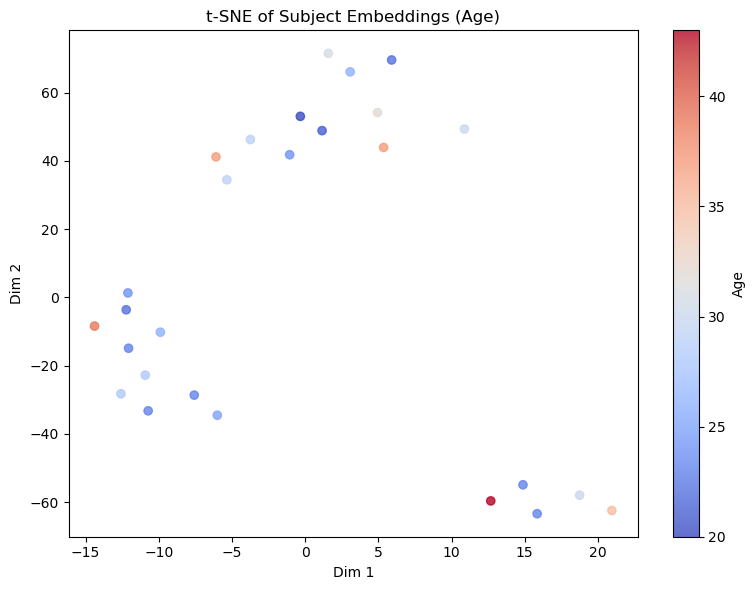

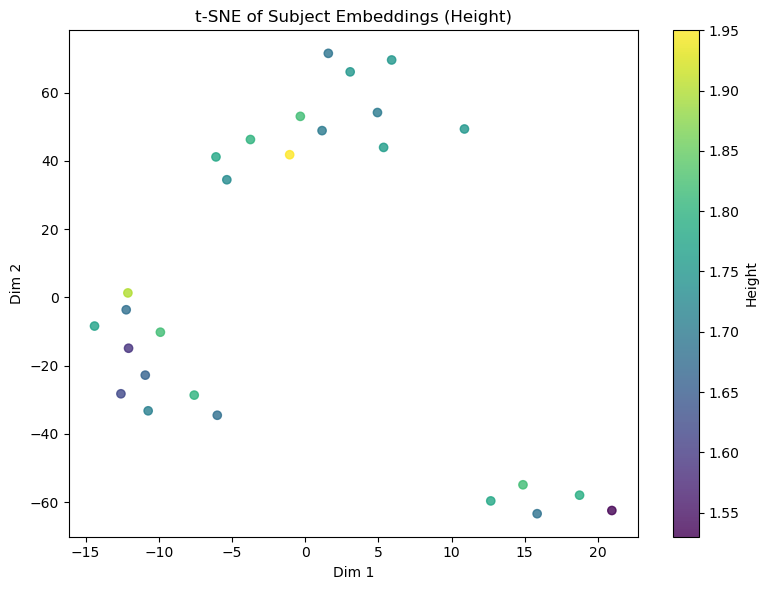

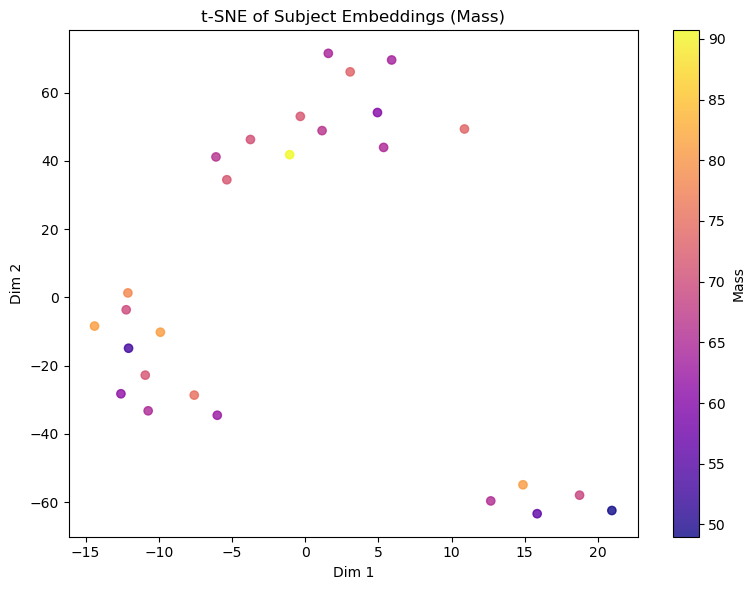

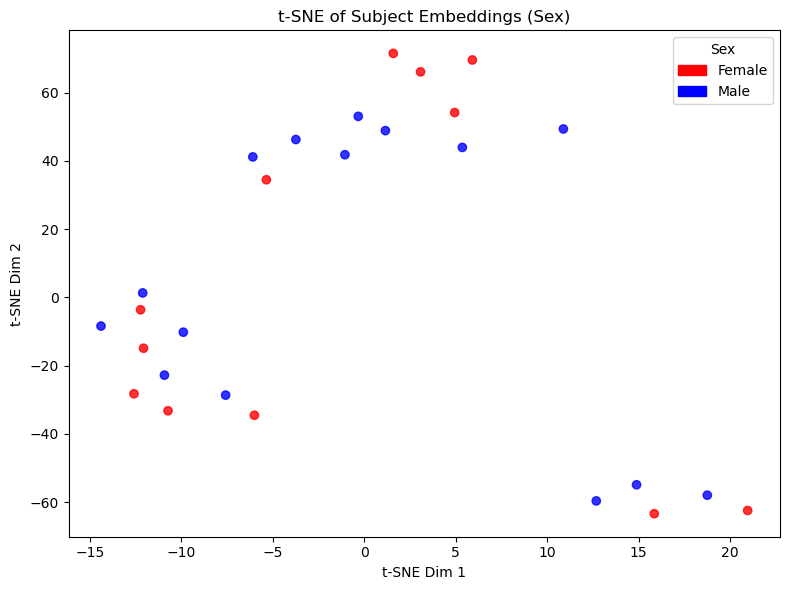

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def plot_heatmap_scatter(embeddings_2d, values, title, cmap='viridis', colorbar_label=None):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=values, cmap=cmap, alpha=0.8)
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    cbar = plt.colorbar(scatter)
    if colorbar_label:
        cbar.set_label(colorbar_label)
    plt.tight_layout()
    plt.show()

def to_numeric(arr):
    arr = np.array(arr)
    mask = arr == 'unknown'
    arr_num = np.where(mask, np.nan, arr).astype(float)
    return arr_num

embeddings = []
ages = []
heights = []
masses = []
sexes = []

subject_list = sorted(subject_latents.keys())
for subject in subject_list:
    latents = subject_latents[subject]
    if len(latents) == 0:
        continue
    latents_tensor = torch.stack(latents).to(device)
    meta_vec, biomech_vec, time_vec = get_features(subject)
    meta_tensor = torch.tensor(meta_vec, device=device).unsqueeze(0).repeat(latents_tensor.shape[0], 1)
    biomech_tensor = torch.tensor(biomech_vec, device=device).unsqueeze(0).repeat(latents_tensor.shape[0], 1)
    time_tensor = torch.tensor(time_vec, device=device).unsqueeze(0).repeat(latents_tensor.shape[0], 1)
    with torch.no_grad():
        profile_vectors = encoder(latents_tensor, meta_tensor, biomech_tensor, time_tensor).detach().cpu().numpy()
        profile = profile_vectors.mean(axis=0)
    meta = dataset.subject_metadata.get(subject, {})
    age = meta.get('age', 'unknown')
    height = meta.get('height', 'unknown')
    mass = meta.get('mass', 'unknown')
    sex = meta.get('sex', 'unknown')
    if age == 'unknown' or age == 0:
        continue
    embeddings.append(profile)
    ages.append(age)
    heights.append(height)
    masses.append(mass)
    sexes.append(sex)

embeddings = np.stack(embeddings)

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
embeddings_2d_tsne = tsne.fit_transform(embeddings)

# For sex, use blue for male and red for female, add a key/legend (no text inside dots)
sexes_arr = np.array(sexes)
sex_to_num = {'female': 0, 'male': 1}
sex_numeric = np.array([sex_to_num.get(s, np.nan) for s in sexes_arr])
cmap_sex = ListedColormap(['red', 'blue'])
legend_handles = [
    mpatches.Patch(color='red', label='Female'),
    mpatches.Patch(color='blue', label='Male')
]

# --- t-SNE plots ---
plot_heatmap_scatter(embeddings_2d_tsne, to_numeric(ages), "t-SNE of Subject Embeddings (Age)", cmap='coolwarm', colorbar_label='Age')
plot_heatmap_scatter(embeddings_2d_tsne, to_numeric(heights), "t-SNE of Subject Embeddings (Height)", cmap='viridis', colorbar_label='Height')
plot_heatmap_scatter(embeddings_2d_tsne, to_numeric(masses), "t-SNE of Subject Embeddings (Mass)", cmap='plasma', colorbar_label='Mass')

plt.figure(figsize=(8, 6))
scatter = plt.scatter(embeddings_2d_tsne[:, 0], embeddings_2d_tsne[:, 1], c=sex_numeric, cmap=cmap_sex, alpha=0.8)
plt.title("t-SNE of Subject Embeddings (Sex)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend(handles=legend_handles, title="Sex", loc='best')
plt.tight_layout()
plt.show()
